## Example 5 – Two state variables
### Time-Varying Drift and Diffusion – Zero-Coupon Bond
Here the setup is more complicated, having two state variables. Both consumption drift and diffusion are simultaneously time-varying. The modified processes that will give the price of the zero coupon security are the following (where $\hat{x}_1$ and $\hat{x}_2$ revert to $\bar{x}_1$ and $\bar{x}_2$ respectively):

$$
\mathrm{d}c_{t}=\mu_{ct}\mathrm{d}t+\sigma_{ct}(1-|\rho_{c1}|-|\rho_{c2}|)\mathrm{d}W_{ct} +\sigma_{ct}\rho_{cx1}\mathrm{d}W_{x1t}+\sigma_{ct}\rho_{cx1}\mathrm{d}W_{x2t}\\
\mathrm{d}\hat{x}_{1t}=\big(-\log\phi\cdot(\bar{x}_{1}-\hat{x}_{1t}) +\rho_{cx1}\sigma_{ct}\sigma_{1x}\big)\mathrm{d}t+\sigma_{x1}\frac{1}{1+\rho_{12}}\mathrm{d}W_{x1t} +\sigma_{x1}\frac{\rho_{12}}{1+\rho_{12}}\mathrm{d}W_{x2t}\\
\mathrm{d}\hat{x}_{2t}=\big(-\log\phi\cdot(\bar{x}_{2}-\hat{x}_{2t}) +\rho_{cx2}\sigma_{ct}\sigma_{x2}\big)\mathrm{d}t+\sigma_{x2}\frac{\rho_{21}}{1+\rho_{21}}\mathrm{d}W_{x1t} +\sigma_{x2}\frac{1}{1+\rho_{21}}\mathrm{d}W_{x2t}
$$

where $W_{c1}$, $W_{x1}$ and $W_{x2}$ are independent and:
$$\mathrm{E}[\mathrm{d}c_{t}\mathrm{d}\bar{x}_{1t}]=\bigg(\rho_{cx1}\frac{1}{1+\rho_{12}}+\rho_{cx2}\frac{\rho_{12}}{1+\rho_{12}}\bigg)\sigma_{ct}\sigma_{x1}\mathrm{d}t\approxeq \rho_{cx1}\sigma_{ct}\sigma_{x1}\mathrm{d}t $$
$$\mathrm{E}[\mathrm{d}c_{t}\mathrm{d}\bar{x}_{2t}]=\bigg(\rho_{cx2}\frac{1}{1+\rho_{21}}+\rho_{cx1}\frac{\rho_{21}}{1+\rho_{21}}\bigg)\sigma_{ct}\sigma_{x2}\mathrm{d}t\approxeq \rho_{cx2}\sigma_{ct}\sigma_{x2}\mathrm{d}t $$
$$\mathrm{E}[\mathrm{d}\bar{x}_{1t}\mathrm{d}\bar{x}_{2t}]=\sigma_{x1}\sigma_{x2}\frac{\rho_{21}+\rho_{12}}{1+\rho_{12}+\rho_{21}+\rho_{12}\rho_{21}}\mathrm{d} t\approxeq (\rho_{12}+\rho_{21})\sigma_{x1}\sigma_{x2}\mathrm{d}t$$


and the approximate equations are valid if $\rho_{12}$ and $\rho_{21}$ are small.

In order to get the price of the zero-coupon security a process for the integral of the short-term rate will also be needed:

$$
\mathrm{d}\mathcal{I} = r(\hat{x}_{1t},\hat{x}_{2t})\mathrm{d}t
$$

##### Import the packages

In [1]:
import SDFPricing as sdf
import StochasticDiffEq as sde # this is needed in order to specify the algorithm

[ Info: Precompiling SDFPricing [8f91c045-db67-4ada-b18f-1d80840c3158]


#### Define the parameters

In [2]:
cs = (
    phi1 = 0.91, # mean reversion
    phi2 = 0.96, # mean reversion
    xbar1 = 0.0, # long-run mean
    xbar2 = 0.0, # long-run mean
    rho = 0.02, # time preference parameter
    gamma = 2.0, # risk aversion
    muc = 0.005, # mean of consumption drift
    sigmac = 0.08, # mean of consumption diffusion
    sigmax1 = 0.005, # volatility
    sigmax2 = 0.2, # volatility
    rhocx1 = 0.0, # correlation parameter
    rhocx2 = -0.6, # correlation parameter
    rho12 = 0.1, # correlation parameter
    rho21 = 0.1 # correlation parameter
    );

#### Drift and Diffusion of the processes
I also include the unmodified process which will correspond to "risk-neutral pricing". By comparing normal pricing with risk-neutral pricing it is possible to compute excess returns.

In [3]:
###- now consumption diffusion is a non-linear function of the state, 
###- given that it needs to be positive.
###- I use this function because the simple exponential can get too high for some samples.
sigmac(x,c) = c.sigmac*(x<0 ? 2/(1+exp(-2x)) : 4/(1+exp(-x))-1);
muc(x,c) = c.muc + x;
sigmac(x) = sigmac(x,cs);
sigma1_1(x,c) = c.sigmax1/(1+c.rho12); 
sigma1_2(x,c) = c.sigmax1*c.rho12/(1+c.rho12); 
sigma1(x,c) = sigma1_1(x,c)+sigma1_2(x,c);
sigma2_1(x,c) = c.sigmax2*c.rho21/(1+c.rho21); 
sigma2_2(x,c) = c.sigmax2/(1+c.rho21); 
sigma2(x,c) = sigma2_1(x,c)+sigma2_2(x,c);
mu1(x,c) = -log(c.phi1)*(c.xbar1-x)-c.gamma*sigmac(x,c)*(sigma1_1(x,c)*c.rhocx1+sigma1_2(x,c)*c.rhocx2); # drift of modified state
mu2(x,c) = -log(c.phi2)*(c.xbar2-x)-c.gamma*sigmac(x,c)*(sigma2_1(x,c)*c.rhocx1+sigma2_2(x,c)*c.rhocx2); # drift of modified state
mu10(x,c) = -log(c.phi1)*(c.xbar1-x); # drift of unmodified state
mu20(x,c) = -log(c.phi2)*(c.xbar2-x); # drift of unmodified state


#### Short-term rate function

In [4]:
r(x1,x2,c) = c.rho+c.gamma*muc(x1,c)-c.gamma^2*sigmac(x2,c)^2/2;
r(x1,x2) = r(x1,x2,cs);

#### Define setup consistent with SDE solution in Julia

In [5]:
function drift(du,u,p,t,c)
    du[1] = mu1(u[1],c)
    du[2] = mu2(u[2],c)
    du[3] = mu10(u[3],c)
    du[4] = mu20(u[4],c)
    du[5] = r(u[1],u[2],c)
    du[6] = r(u[3],u[4],c)
end
drift(du,u,p,t) = drift(du,u,p,t,cs);
function diffusion(du,u,p,t,c)
    du[1, 1] = sigma1_1(u[1], c)
    du[1, 2] = sigma1_2(u[1], c)
    du[2, 1] = sigma2_1(u[2], c)
    du[2, 2] = sigma2_2(u[2], c)
    du[3, 1] = sigma1_1(u[3], c)
    du[3, 2] = sigma1_2(u[3], c)
    du[4, 1] = sigma2_1(u[4], c)
    du[4, 2] = sigma2_2(u[4], c)
    du[5, 1] = 0.0
    du[5, 2] = 0.0
    du[6, 1] = 0.0
    du[6, 2] = 0.0
end
diffusion(du,u,p,t) = diffusion(du,u,p,t,cs);

#### Define the Problem and SolutionSettings variables

In [6]:
prob = sdf.Problem(drift=drift,diffusion=diffusion,numNoiseVariables=2,outVariables=[5,6],
terminalFunction=(ik, x, y, z) -> exp(-x),diagonalNoise=false);
xRanges = [-0.03:0.005:0.03,-2.0:0.4:2.0];
tRange = 0.0:1.0:20.0;
sett = sdf.SolutionSettings(xRanges=xRanges, initialValues=vcat([[x, y,x,y, 0.0,0.0] for y in xRanges[2] for x in xRanges[1]]), 
algorithm=sde.LambaEM(), pathsPerInitialValue=5000, tRange=tRange);

#### Solve Problem and Define Yield

In [7]:
((bondPrice,riskNeutralPrice),) = sdf.solve(prob, sett);
yld(t,x1,x2) = -log(bondPrice(t,x1,x2))/t;
yldRiskNeutral(t,x1,x2) = -log(riskNeutralPrice(t,x1,x2))/t;

#### Plot the Yield in 3D

In [12]:
import Plots as plt
import PlotlyJS as pltjs
coordinates = pltjs.surface(
    z=[100*yld(10.0, x1, x2) for x1 in xRanges[1], x2 in xRanges[2]], x=xRanges[1],
    y=100*sigmac.(xRanges[2]),
    showscale=false)

layout = pltjs.Layout(
    width=800, height=350,
    title_x=0.5,
    titlefont_size="16",
    scene_aspectratio=pltjs.attr(x=1, y=1, z=0.5),
    scene=pltjs.attr(
        xaxis=pltjs.attr(title="cons. drift"),
        yaxis=pltjs.attr(title="cons. diffusion"),
        zaxis=pltjs.attr(title="yield"),
        camera=pltjs.attr(
            center=pltjs.attr(x=0.3, y=0, z=-0.40),
            eye=pltjs.attr(x=-.95, y=-1.25, z=0.65)
        )
    ),
    font=pltjs.attr(family="Computer Modern", size=12, color="black"),
    margin=pltjs.attr(l=0, r=0, b=0, t=0, pad=0))
   pltjs.plot([coordinates], layout)


"3dPlot.png"

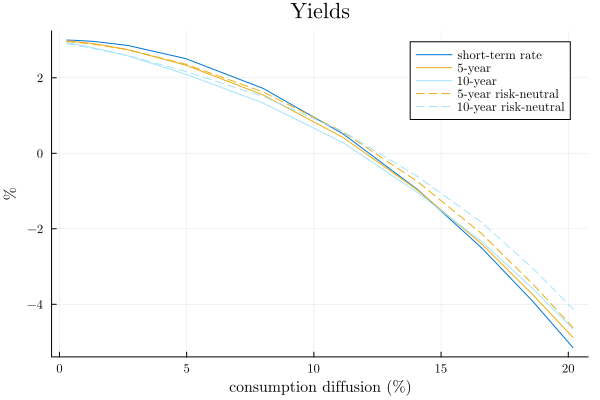

In [9]:
# colors: "#0075d6", "#edad14", "#a3e3ff", "#9c0000"
import Plots as plt
x1 = 0.0
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(100*sigmac.(xRanges[2]), xRanges[2] .|> x2->100*r(x1,x2), title="Yields",
    xlabel="consumption diffusion (%)",ylabel="%",label="short-term rate",color="#0075d6")
plt.plot!(100*sigmac.(xRanges[2]), 100*yld.(5.0, x1,xRanges[2]), label="5-year",color= "#edad14")
plt.plot!(100*sigmac.(xRanges[2]), 100*yld.(10.0, x1,xRanges[2]), label="10-year",color="#a3e3ff")
plt.plot!(100*sigmac.(xRanges[2]), 100*yldRiskNeutral.(5.0, x1,xRanges[2]), label="5-year risk-neutral",color= "#edad14",style=:dash)
plt.plot!(100*sigmac.(xRanges[2]), 100*yldRiskNeutral.(10.0, x1,xRanges[2]), label="10-year risk-neutral",color="#a3e3ff",style=:dash)

Focusing on one state variable shows that the results are similar to the single variable case.